# Detailed Surplus Estimate #

## Introduction ##

(Note: This is a follow-up to <a href="https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/">this analysis</a>, specifically the section *The Limits of the ActaLog Data*.)

To calculate the number of verification-eligible acta columns, at minimum I'd need to know:
* When the TREP's bo2 server received the initial transcription from the polling place. (<code>MobileTranscript</code>)
* When the TREP's bo2 server received the acta image from the polling place. (<code>MobileImage</code>)
* When the TREP's bo2 server sent the acta column to a user at SERECI La Paz for verification. (<code>SereciServed</code>)
* <strike>When the TREP's bo2 server had acta images marked as valid or invalid. (<code>ImageValid</code>)</strike>

I only have <code>MobileTranscript</code>, so it's not possible to do the calculation. But what if I estimate the others?

## Preparations ##

### Libraries ###

In [1]:
# Standard libraries.
import numpy as np
import pandas as pd

In [2]:
# Graphing libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Settings ###

In [3]:
# Graph settings.
sns.set_theme(palette='bright')
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['figure.figsize'] = np.array(plt.rcParamsDefault['figure.figsize']) * 1.25

### Data ###

In [4]:
# load data
trep = pd.read_parquet('data/OEA_TREP_LogCompleto_19G_2019.11.03.06.53.parquet')
computo = pd.read_parquet('data/2.RecepcionSobres_final.parquet').set_index(['NumMesa', 'ElecActa'])

In [5]:
# Sort the events chronologically, with a simple generic timestamp.
trep.rename(columns={'Fecha Registro en Log': 'GenericTimestamp'}, inplace=True)   
trep.sort_values('GenericTimestamp', inplace=True)

In [6]:
# Define which type of user provided the transcription.
trep['UserType'] = np.where(
    trep.EstadoActa == 'Registrada',
    'MobileUser',
    np.where(
        trep.AprobadorDate.isna(),
        'SereciVerifier',
        'SereciApprover'
    )
)

In [7]:
# Drop SereciApprover transcriptions, which I don't care about.
trep.drop(
    index=trep[trep.UserType == 'SereciApprover'].index,
    inplace=True
)

### Convenience Functions ###

In [8]:
# Utility function for keeping columns in chronological order.
def _sort_datetime_columns(df):
    if ~np.all([pd.api.types.is_datetime64_dtype(x) for x in df.dtypes]):
        raise ValueError('expected all columns to be datetime64')   
    return df[df.dropna().rank(axis=1).mean(axis=0).sort_values().index].copy()
pd.DataFrame.sort_datetime_columns = _sort_datetime_columns

In [9]:
# Common formatters.
pct_format = mpl.ticker.PercentFormatter(1)
hhmm_format = mpl.dates.DateFormatter('%H:%M')

# Function to set graph axis formatter (in chaining-style).
def _formatter(axis, formatter):
    axis.set_major_formatter(formatter)
    return axis.axes
mpl.axis.XAxis.formatter = _formatter

In [10]:
# Draw red vertical spans where high-traffic periods are.
def _hi_traffic_spans(ax):
    ax.axvspan(*pd.to_datetime(['2019-10-20 17:35', '2019-10-20 18:10']), alpha=0.2, color='red')
    ax.axvspan(*pd.to_datetime(['2019-10-20 19:30', '2019-10-20 20:00']), alpha=0.2, color='red')
    return ax
mpl.axes._axes.Axes.hi_traffic_spans = _hi_traffic_spans

## Analysis ##

### MobileTranscript ###

First I'll grab the <code>MobileTranscript</code> (and <code>SereciTranscript</code>) timestamps that I actually do have:

In [11]:
trep_times = (
    trep.pivot_table(
        index=('NumMesa', 'ElecActa'),
        columns='UserType',
        values='GenericTimestamp',
        aggfunc='min'
    )
    .rename(columns={
        'MobileUser': 'MobileTranscript',
        'SereciVerifier': 'SereciTranscript'
    })
    .rename_axis(columns=None)
)
trep_times

MobileTranscript    SereciTranscript
NumMesa ElecActa                                                           
1001    Presidente y Vicepresidente 2019-10-20 13:10:42 2019-10-20 13:11:56
1002    Presidente y Vicepresidente 2019-10-20 11:41:48 2019-10-20 11:45:29
1003    Presidente y Vicepresidente 2019-10-20 17:27:26 2019-10-20 17:29:26
1004    Presidente y Vicepresidente 2019-10-20 17:34:42 2019-10-20 17:39:41
1005    Presidente y Vicepresidente 2019-10-20 17:05:27 2019-10-20 17:20:15
...                                                 ...                 ...
90387   Presidente y Vicepresidente 2019-10-20 17:47:20 2019-10-20 17:49:51
90388   Diputados Uninominales      2019-10-20 18:57:45 2019-10-20 19:00:52
        Presidente y Vicepresidente 2019-10-20 18:57:43 2019-10-20 18:59:31
90389   Diputados Uninominales      2019-10-20 17:17:59 2019-10-20 17:27:33
        Presidente y Vicepresidente 2019-10-20 17:17:58 2019-10-20 17:25:52

[67400 rows x 2 columns]

To establish a baseline, I'll do the basic surplus estimate right now, using only the <code>MobileTranscript</code> and <code>SereciTranscript</code> timestamps.

In [12]:
# utility function to do a single surplus estimate.
def _calc_surplus(df_times, start_col, end_col):
    return (
        pd.merge(
            df_times.groupby(start_col).size().rename('surplus_in'),
            df_times.groupby(end_col).size().rename('surplus_out'),
            how='outer',
            right_index=True,
            left_index=True,
            sort=True
        )
        .fillna(0)
        .pipe(lambda x: x.surplus_in.cumsum() - x.surplus_out.cumsum())
    )

# utility function to do multiple surplus estimates.
def calculate_surplus(df_times, calc_dict, freq='1Min'):
    return (
        pd.concat(
            [_calc_surplus(df_times, *v).rename(k) for k,v in calc_dict.items()],
            axis=1,
            join='outer',
            sort=True
        )
        .ffill()
        .resample(freq)
        .ffill()
        .fillna(0)
    )

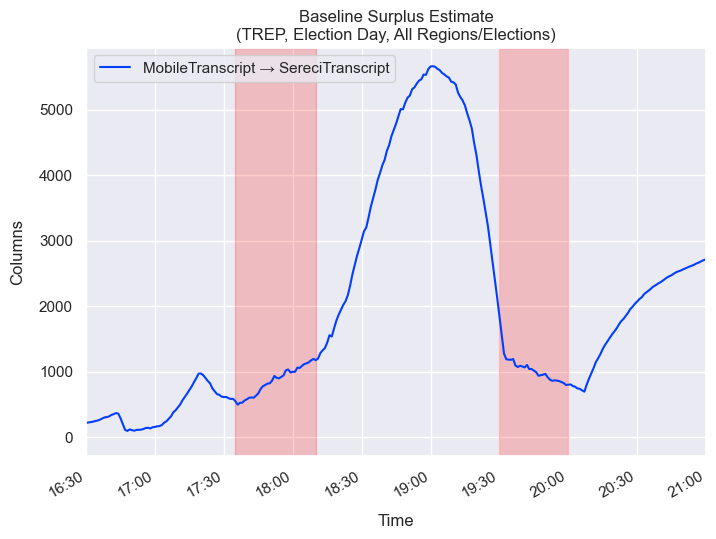

In [13]:
(
    calculate_surplus(
        trep_times,
        {'MobileTranscript → SereciTranscript': ('MobileTranscript', 'SereciTranscript')}
    )
    .plot(
        title='Baseline Surplus Estimate\n(TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=[pd.Timestamp('2019-10-20 16:30'), pd.Timestamp('2019-10-20 21:00')],
        x_compat=True,
        ylabel='Columns'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
    .legend(loc='upper left')
)

This graph should look familiar, since it's the same one that appears in the <a href="https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/">other</a> analysis. I'll need to improve it, though, with the use of other timestamps which I'll have to estimate. To ensure that all the timestamps are internally consistent and make sense, I'll write some simple code to run consistency checks on the data.

In [14]:
# lists of potential consistency problems with specific columns (will fill in later).
_tests = {}

# add a consistency test.
def set_test(column_name, error_name, funct):
    if column_name not in _tests:
        _tests[column_name] = {}
    _tests[column_name][error_name] = funct

# remove a consistency test.
def delete_test(column_name, error_name):
    if (column_name not in _tests) or (error_name not in _tests[column_name]):
        return False
    if len(_tests[column_name]) > 1:
        del _tests[column_name][error_name]
    else:
        del _tests[column_name]
    return True

# run all consistency checks.
def run_tests(normalize=False):
    test_results = {}
    for column_name, column_tests in _tests.items():
        for error_name, test_func in column_tests.items():
            test_results[(column_name, error_name)] = test_func(trep_times).sum()
    test_results = pd.Series(test_results, name='nerrs').rename_axis(index=['column', 'error'])
    if normalize and ~test_results.empty:
        test_results = (test_results / len(trep_times))
    return test_results

First, I'll make sure the <code>MobileTranscript</code> and <code>SereciTranscript</code> are defined, then that <code>MobileTranscript</code> never precedes <code>SereciTranscript</code>.

In [15]:
# run some initial tests.
set_test('MobileTranscript', 'isnull', lambda x: x.MobileTranscript.isna())
set_test('MobileTranscript', '> SereciTranscript', lambda x: (x.MobileTranscript > x.SereciTranscript))
set_test('SereciTranscript', 'isnull', lambda x: x.SereciTranscript.isna())
run_tests()

column            error             
MobileTranscript  isnull                 0
                  > SereciTranscript     0
SereciTranscript  isnull                77
Name: nerrs, dtype: int64

There are 77 records with no <code>SereciTranscript</code> time. To make them easier to process, I'll assign them an arbitrary post-election timestamp.

In [16]:
trep_times.SereciTranscript.fillna(pd.Timestamp('2019-11-10 05:05'), inplace=True)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
Name: nerrs, dtype: int64

### SereciServed ###

Next, I have to estimate <code>SereciServed</code>. As it happens, there's a moderately sensible way to do this. If you assume verification operators worked non-stop, then once one of them finished with one acta column, they were immediately served the next one. If you list a user's verification attempts from oldest to newest, <code>SereciServed</code> should be the user's previous attempt (plus a second or two). There are some issues, though. First, acta columns that were a user's first verification attempt won't have a <code>SereciServed</code> time because the user had no previous attempt. Second, if a user stops working, maybe due to a shortage of acta columns, then <code>SereciServed</code> will precede the time when the user actually received the acta column. Finally, if a user rejects an acta column in a way that doesn't show up in the ActaLog data, such as marking the acta image as "invalid," it'll have a similar effect. Overall, this estimate isn't bad, but it's only a lower bound on when a column was served out.

So, I'll calculate <code>SereciServed</code> then add it to the dataframe:

In [17]:
time_to_press_button = pd.Timedelta('2s')
trep_times = trep_times.join(
    time_to_press_button + (
        trep[trep.UserType == 'SereciVerifier']
            .set_index(['NumMesa', 'ElecActa'])
            .groupby('VerificadorUser')
            .VerificadorDate.shift()
            .rename('SereciServed')
    )
).sort_datetime_columns()
trep_times

MobileTranscript        SereciServed  \
NumMesa ElecActa                                                              
1001    Presidente y Vicepresidente 2019-10-20 13:10:42 2019-10-20 13:11:35   
1002    Presidente y Vicepresidente 2019-10-20 11:41:48 2019-10-20 11:45:06   
1003    Presidente y Vicepresidente 2019-10-20 17:27:26 2019-10-20 17:29:07   
1004    Presidente y Vicepresidente 2019-10-20 17:34:42 2019-10-20 17:39:15   
1005    Presidente y Vicepresidente 2019-10-20 17:05:27                 NaT   
...                                                 ...                 ...   
90387   Presidente y Vicepresidente 2019-10-20 17:47:20 2019-10-20 17:49:30   
90388   Diputados Uninominales      2019-10-20 18:57:45 2019-10-20 18:58:44   
        Presidente y Vicepresidente 2019-10-20 18:57:43 2019-10-20 18:58:48   
90389   Diputados Uninominales      2019-10-20 17:17:59 2019-10-20 17:27:06   
        Presidente y Vicepresidente 2019-10-20 17:17:58 2019-10-20 17:25:02   

                                       SereciTranscript  
NumMesa ElecActa                                         
1001    Presidente y Vicepresidente 2019-10-20 13:11:56  
1002    Presidente y Vicepresidente 2019-10-20 11:45:29  
1003    Presidente y Vicepresidente 2019-10-20 17:29:26  
1004    Presidente y Vicepresidente 2019-10-20 17:39:41  
1005    Presidente y Vicepresidente 2019-10-20 17:20:15  
...                                                 ...  
90387   Presidente y Vicepresidente 2019-10-20 17:49:51  
90388   Diputados Uninominales      2019-10-20 19:00:52  
        Presidente y Vicepresidente 2019-10-20 18:59:31  
90389   Diputados Uninominales      2019-10-20 17:27:33  
        Presidente y Vicepresidente 2019-10-20 17:25:52  

[67400 rows x 3 columns]

But there's two problems with <code>SereciServed</code>. First, 439 of the timestamps are blank:

In [18]:
set_test('SereciServed', 'isnull', lambda x: x.SereciServed.isna())
run_tests()

column            error             
MobileTranscript  isnull                  0
                  > SereciTranscript      0
SereciTranscript  isnull                  0
SereciServed      isnull                439
Name: nerrs, dtype: int64

Of the 439, 362 are because it was the user's first ever verification attempt and the other 77 are because the acta column never had a verification attempt.

There are also some impossibly early <code>SereciServed</code> times. A simple approach to detect these is to check for <code>SereciServed < MobileTranscript</code>. Acta columns can't get served out to verification operators *before* their first transcript is recorded, since the first transcript is required for the acta column to be eligible for verification.

So, I'll add a check for <code>SereciServed < MobileTranscript</code>, then run the tests again:

In [19]:
set_test('SereciServed', '< MobileTranscript', lambda x: (x.MobileTranscript > x.SereciServed))
run_tests(normalize=True)

column            error             
MobileTranscript  isnull                0.000000
                  > SereciTranscript    0.000000
SereciTranscript  isnull                0.000000
SereciServed      isnull                0.006513
                  < MobileTranscript    0.099733
Name: nerrs, dtype: float64

Almost 10% of the records have this issue. I don't want to drop records over early or blank <code>SereciServed</code> times, though, so I'll replace them with:

<code>SereciTranscript - SereciUser.TimeBetweenVerifs.median() + TimeToClickButton</code>

In other words, I'll assume the user spent what, for them, would be a moderate amount of time transcribing an acta column.

In [20]:
UserTimeBetweenVerifs = (
    trep.loc[
        trep.UserType == 'SereciVerifier',
        ['NumMesa', 'ElecActa', 'VerificadorUser', 'VerificadorDate']
    ]
        .pipe(lambda x:
            x.join(
                x.groupby('VerificadorUser')
                    .VerificadorDate.diff()
                    .dt.total_seconds()
                    .rename('SecondsBetweenVerifs')
            )
        )
        .set_index(['NumMesa', 'ElecActa'])
        .groupby('VerificadorUser')
        .SecondsBetweenVerifs.transform('median')
        .pipe(lambda x: pd.to_timedelta(x, unit='s'))
)
trep_times.SereciServed = trep_times.SereciServed.where(
    (trep_times.SereciServed >= trep_times.MobileTranscript),
    (trep_times.SereciTranscript - UserTimeBetweenVerifs + time_to_press_button)
)
run_tests(normalize=True)

column            error             
MobileTranscript  isnull                0.000000
                  > SereciTranscript    0.000000
SereciTranscript  isnull                0.000000
SereciServed      isnull                0.001142
                  < MobileTranscript    0.024407
Name: nerrs, dtype: float64

There are still 2.4% of records with bad <code>SereciServed</code> times. For those I'll use <code>SereciTranscript</code>, the latest possible value of <code>SereciServed</code>.

In [21]:
trep_times.SereciServed = trep_times.SereciServed.where(
    (trep_times.SereciServed >= trep_times.MobileTranscript),
    trep_times.SereciTranscript # this *inflates* the surplus estimate, making it equivalent to the basic actalog-based estimate.
)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
Name: nerrs, dtype: int64

That's it for the <code>SereciServed</code> tests, but before I move on, I'll redo the first estimate and compare it to one with <code>SereciServed</code>.

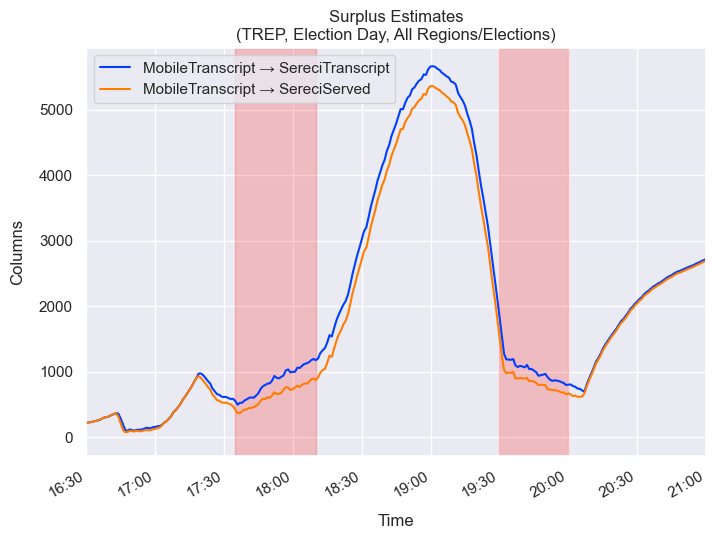

In [22]:
(
    calculate_surplus(
        trep_times,
        {
            'MobileTranscript → SereciTranscript': ('MobileTranscript', 'SereciTranscript'),
            'MobileTranscript → SereciServed': ('MobileTranscript', 'SereciServed')
        }
    )
    .plot(
        title='Surplus Estimates\n(TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=[pd.Timestamp('2019-10-20 16:30'), pd.Timestamp('2019-10-20 21:00')],
        x_compat=True,
        ylabel='Columns'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
    .legend(loc='upper left')
)

So, it got a little shave, but that's all.

### MobileImage ###

Next, I need <code>MobileImage</code>. This one is harder than <code>SereciServed</code>, but I have a trick to help me.

When a transmission operator used their mobile phone to send an acta photo, the image traveled this path:
<blockquote>phone → bo11 → bo2 → bo2s → bo3</blockquote>

(Note: bo11 was a TREP reverse proxy and bo2, bo2s, and bo3 were TREP application servers.)

However, for *overseas* polling stations, once the image hit bo2, it also forked to this path into the Cómputo system (<a href="https://drive.google.com/file/d/1MP4WZmDejLAmygNIsouyPjjttVDCk2vh/view?usp=sharing">BISITE</a>, p154):
<blockquote>bo2 → oep1 → oep2 → bo5 → bo4</blockquote>

(Note: oep1 was a Cómputo reverse proxy and oep2, bo5, and bo4 were Cómputo application servers.)

While I might not have <code>MobileImage</code>, I do have a Cómputo dataset with image transmission times and IP addresses. This dataset has records of image transmissions directly from the bo2 server, whose public IP address (<code>3.231.68.158</code>) is the origin IP address for 1452 records, all from overseas. So, I'll add those times.

In [23]:
bo2_pub_ip = '3.231.68.158'
trep_times = trep_times.join(
    computo.loc[
        computo['IP Primera Transmisión Imagen'] == bo2_pub_ip,
        'Primera Transmisión Imagen'
    ].rename('ComputoImage')
).sort_datetime_columns()
trep_times

MobileTranscript        ComputoImage  \
NumMesa ElecActa                                                              
1001    Presidente y Vicepresidente 2019-10-20 13:10:42 2019-10-20 13:12:00   
1002    Presidente y Vicepresidente 2019-10-20 11:41:48 2019-10-20 11:42:00   
1003    Presidente y Vicepresidente 2019-10-20 17:27:26 2019-10-20 17:29:00   
1004    Presidente y Vicepresidente 2019-10-20 17:34:42 2019-10-20 17:39:00   
1005    Presidente y Vicepresidente 2019-10-20 17:05:27 2019-10-20 17:07:00   
...                                                 ...                 ...   
90387   Presidente y Vicepresidente 2019-10-20 17:47:20                 NaT   
90388   Diputados Uninominales      2019-10-20 18:57:45                 NaT   
        Presidente y Vicepresidente 2019-10-20 18:57:43                 NaT   
90389   Diputados Uninominales      2019-10-20 17:17:59                 NaT   
        Presidente y Vicepresidente 2019-10-20 17:17:58                 NaT   

                                           SereciServed    SereciTranscript  
NumMesa ElecActa                                                             
1001    Presidente y Vicepresidente 2019-10-20 13:11:35 2019-10-20 13:11:56  
1002    Presidente y Vicepresidente 2019-10-20 11:45:06 2019-10-20 11:45:29  
1003    Presidente y Vicepresidente 2019-10-20 17:29:07 2019-10-20 17:29:26  
1004    Presidente y Vicepresidente 2019-10-20 17:39:15 2019-10-20 17:39:41  
1005    Presidente y Vicepresidente 2019-10-20 17:19:55 2019-10-20 17:20:15  
...                                                 ...                 ...  
90387   Presidente y Vicepresidente 2019-10-20 17:49:30 2019-10-20 17:49:51  
90388   Diputados Uninominales      2019-10-20 18:58:44 2019-10-20 19:00:52  
        Presidente y Vicepresidente 2019-10-20 18:58:48 2019-10-20 18:59:31  
90389   Diputados Uninominales      2019-10-20 17:27:06 2019-10-20 17:27:33  
        Presidente y Vicepresidente 2019-10-20 17:25:02 2019-10-20 17:25:52  

[67400 rows x 4 columns]

However, I only have times for 1452 records, all from overseas. The times for the other records are blank, and those blanks represent 97.8% (!) of all records:

In [24]:
set_test('ComputoImage', 'isnull', lambda x: x.ComputoImage.isna())
run_tests(normalize=True)

column            error             
MobileTranscript  isnull                0.000000
                  > SereciTranscript    0.000000
SereciTranscript  isnull                0.000000
SereciServed      isnull                0.000000
                  < MobileTranscript    0.000000
ComputoImage      isnull                0.978457
Name: nerrs, dtype: float64

Unfortunately, I don't have a way to fill those blank values in. I'll have to drop those records, working only with the 2.2% of records with defined times.

In [25]:
trep_times.dropna(subset='ComputoImage', inplace=True)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
ComputoImage      isnull                0
Name: nerrs, dtype: int64

But that's not the only problem. For some records, it shows the image was replicated to the Cómputo *after* the TREP verification attempt. I assumed when bo2 received an image, it instantly replicated it, but that's not true. In 92 cases, there's a TREP verification attempt (which implies an image on bo2), *then* a Cómputo image replication.

In [26]:
set_test('ComputoImage', '> SereciTranscript', lambda x: x.ComputoImage > x.SereciTranscript)
run_tests()

column            error             
MobileTranscript  isnull                 0
                  > SereciTranscript     0
SereciTranscript  isnull                 0
SereciServed      isnull                 0
                  < MobileTranscript     0
ComputoImage      isnull                 0
                  > SereciTranscript    92
Name: nerrs, dtype: int64

To illustrate, I'll take a random case of this:

In [27]:
(
    trep_times[trep_times.ComputoImage > trep_times.SereciTranscript]
        .sample(n=1, random_state=0)
        .squeeze()
        .sort_values()
        .to_frame('Timestamp')
)

,Timestamp
MobileTranscript,2019-10-20 17:33:05
SereciServed,2019-10-20 17:33:38
SereciTranscript,2019-10-20 17:33:49
ComputoImage,2019-10-20 17:34:00


The TREP verification attempt is at 17:33:49, *then* comes the Cómputo image replication at 17:34:00. The Cómputo image replications might be on a delay, but it's also possible <code>ComputoImage</code> was rounded or ceiling'd to the minute, since all the times in the Cómputo data are at minute-boundaries (ie. their second-offset is 0):

In [28]:
computo.select_dtypes(include='datetime64').apply(lambda x: x.isna() | (x.dt.second == 0)).all(axis=None)

True

I can work around both issues, though, thanks to some information in the <a href="https://drive.google.com/file/d/1MP4WZmDejLAmygNIsouyPjjttVDCk2vh/view?usp=sharing">BISITE</a> report. On p163, there's an nginx log entry from oep1, which was the Cómputo reverse proxy that fronted for oep2. The log entry shows an HTTP request from bo2 (<code>3.231.68.158</code>) that replicated station #2322's image from bo2 to oep1:

<code>3.231.68.158 - - [20/Oct/2019:11:22:36 -0400] "POST /simobol_2019_3_Computo/registroImagenActa?sid3User=simoreplica&sid3pwd=20simogua15&NumMesa=2322&NumImagen=1&Fase=2&Valida=1&TransmisionUser=gacunasuarez&TransmisionFullName=GUSTAVO+ACU%C3%91A+SUAREZ&TransmisionDate=1571584917000&TransmisionIP=95.63.159.20 HTTP/1.1" 200 34 "-" "ApacheHttpClient/4.5 (Java/1.8.0_222)"</code>

I think the URL parameters correspond to fields in bo2's ActaImagenLog table, whose record for station #2322 was copied here (plus some login credentials). Some of the fields are of interest to me. For example, *Valida* was probably related to that SERECI call center. Of greater interest to me, however, is the *TransmisionDate* field, which appears to be the TREPbo2 server's time of reception for this image. It's in UNIX format and is equal to: '20/Oct/2019:11:21:57 -0400'. This is 39 seconds before the nginx log entry's time of '20/Oct/2019:11:22:36 -0400', so it looks bo2 held the image for 39 seconds before transmitting it to oep1. This seems like too long for it to be due to network latency or server load, especially since almost no data was being received or processed at 11:22 AM on Election Day. It must be some kind of programmed delay. And sure enough, in Marcel Guzmán de Rojas's witness statement (<a href="https://drive.google.com/file/d/1qmgB3Q3ZpXtVvLhQJj-rJHoL7MuIXQML/view">*Sobreseimiento*</a>, p22), he says that bo2's data replication process ran on a *one-minute timer*:

<blockquote>La información llega primero a bo2, tanto de los teléfonos como de los verificadores, ahí se procesan y ahí se almacenan, y después <strong>una vez al minuto</strong> (énfasis mío), bo2 [recoge] todas las actas nuevas, las imágenes nuevas, las transmite al bo2s...</blockquote>

This aligns with the timestamps in the nginx log that show bo2 held #2322's image for 39 seconds (ie. inside the 1-minute timer), then sent it to oep1.

The other problem I have is that all the Cómputo dataset's timestamps are on minute boundaries, so a round, floor, or ceiling operation must've been applied to them. Once again, the nginx log entry can help here. To analyze this closer, I'll gather all the image timestamps I have for station #2322 to see if I can make sense of them.

| Origin  | Destination  | Data Source | Timestamp |
| --- | --- | --- | --- |
| bo11 | bo2 | BSIITE's oep1 nginx Log | 2019-10-20 11:21:57 |
| bo2 | oep1 | BISITE's oep1 nginx Log | 2019-10-20 11:22:36 | 
| oep1 | oep2 | DNTIC's Cómputo Spreadsheet | 2019-10-20 11:22:00 |

If *bo11 → bo2* was at 11:21:57 and *bo2 → oep1* was at 11:22:36, then *oep1 → oep2* must've been at 11:22:36 or later. But if you round or ceiling that to the minute, you get 11:23:00 or later, not 11:22:00. Therefore, #2322's Cómputo image transmission time of 11:22:00—and, one assumes, all others too—must be from a *floor* operation.

So, I now have two useful facts:

* The bo2 server replicated new images once per minute.
* The timestamps in the Cómputo dataset were floored to the minute.

Putting these facts together, if I wanted to estimate when #2322's acta image reached the bo2 server based only on the Cómputo image timestamp, then I'd say that the floored Cómputo image time of 11:22:00 implies that *bo2 → oep1 → oep2* was between 11:22:00 and 11:22:59. And since bo2 replicated on a 1-minute timer, it must've received the image between 11:21:00 and 11:22:59, a range which contains #2322's actual bo2 image reception time of 11:21:57 from the oep1 nginx log entry.

In general, the range of bo2 image reception times should be:

<code>[ComputoImage - 1min, ComputoImage + 59sec]</code>

So I'll create two new fields, one with the minimum bound (which I'll call <code>MobileImageMin</code>) and one with the maximum (<code>MobileImageMax</code>):

In [29]:
trep_times['MobileImageMin'] = (trep_times['ComputoImage'] - pd.Timedelta('1min'))
trep_times['MobileImageMax'] = (trep_times['ComputoImage'] + pd.Timedelta('59s'))
trep_times = trep_times.sort_datetime_columns()
trep_times

,,MobileImageMin,MobileTranscript,ComputoImage,SereciServed,MobileImageMax,SereciTranscript
NumMesa,ElecActa,,,,,,
1001,Presidente y Vicepresidente,2019-10-20 13:11:00,2019-10-20 13:10:42,2019-10-20 13:12:00,2019-10-20 13:11:35.000,2019-10-20 13:12:59,2019-10-20 13:11:56
1002,Presidente y Vicepresidente,2019-10-20 11:41:00,2019-10-20 11:41:48,2019-10-20 11:42:00,2019-10-20 11:45:06.000,2019-10-20 11:42:59,2019-10-20 11:45:29
1003,Presidente y Vicepresidente,2019-10-20 17:28:00,2019-10-20 17:27:26,2019-10-20 17:29:00,2019-10-20 17:29:07.000,2019-10-20 17:29:59,2019-10-20 17:29:26
1004,Presidente y Vicepresidente,2019-10-20 17:38:00,2019-10-20 17:34:42,2019-10-20 17:39:00,2019-10-20 17:39:15.000,2019-10-20 17:39:59,2019-10-20 17:39:41
1005,Presidente y Vicepresidente,2019-10-20 17:06:00,2019-10-20 17:05:27,2019-10-20 17:07:00,2019-10-20 17:19:55.000,2019-10-20 17:07:59,2019-10-20 17:20:15
...,...,...,...,...,...,...,...
2503,Presidente y Vicepresidente,2019-10-20 14:45:00,2019-10-20 14:45:26,2019-10-20 14:46:00,2019-10-20 14:50:36.000,2019-10-20 14:46:59,2019-10-20 14:51:31
2504,Presidente y Vicepresidente,2019-10-20 14:47:00,2019-10-20 14:46:41,2019-10-20 14:48:00,2019-10-20 14:47:40.500,2019-10-20 14:48:59,2019-10-20 14:48:31
2505,Presidente y Vicepresidente,2019-10-20 14:52:00,2019-10-20 14:51:58,2019-10-20 14:53:00,2019-10-20 15:02:33.000,2019-10-20 14:53:59,2019-10-20 15:05:32


Next I'll run checks on this image range. To start, I'll check for <code>MobileImageMin > SereciTranscript</code>. This wouldn't make sense because an acta column can't be verified before its image is received. I wouldn't expect to find any cases like this because <code>MobileImageMin</code> and <code>SereciTranscript</code> should be reliable.

In [30]:
# delete all 'ComputoImage' tests, since i'm working with [MobileImageMin, MobileImageMax] now.
delete_test('ComputoImage', '> SereciTranscript')
delete_test('ComputoImage', 'isnull')

# add the 'MobileImageMin' test.
set_test('MobileImageMin', '> SereciTranscript', lambda x: x.MobileImageMin > x.SereciTranscript)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
MobileImageMin    > SereciTranscript    3
Name: nerrs, dtype: int64

There are three cases where <code>MobileImageMin > SereciTranscript</code>, which shouldn't happen.

In [31]:
trep_times.loc[
    trep_times.MobileImageMin > trep_times.SereciTranscript,
    ['MobileTranscript', 'SereciTranscript', 'ComputoImage']
].sort_values('MobileTranscript')

,,MobileTranscript,SereciTranscript,ComputoImage
NumMesa,ElecActa,,,
2056,Presidente y Vicepresidente,2019-10-20 04:28:49,2019-10-20 05:21:28,2019-10-20 05:57:00
2482,Presidente y Vicepresidente,2019-10-20 04:53:55,2019-10-20 05:27:13,2019-10-20 05:57:00
2054,Presidente y Vicepresidente,2019-10-20 05:21:42,2019-10-20 05:36:32,2019-10-20 05:57:00


It seems all three were due to issues with overseas image replications early on Election Day (<a href="https://drive.google.com/file/d/1BMb6_GKlj5a0uzTWX3PHGPrquCizd9iV/view">EHC</a>, p26). If you look at the times above, you'll see that once this problem was resolved, all three were replicated at the same time around 5:57:00. I'm going to drop the three records, since they're an edge case not relevant to this analysis.

In [32]:
trep_times.drop(
    index=trep_times[trep_times.MobileImageMin > trep_times.SereciTranscript].index,
    inplace=True
)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
MobileImageMin    > SereciTranscript    0
Name: nerrs, dtype: int64

Next, I'll look for cases where <code>MobileImageMin > SereciServed</code> since an acta column shouldn't be served before its image is on the server. Unlike <code>MobileImageMin > SereciTranscript</code>, I expect a few of these since <code>SereciServed</code> is a simple estimate that won't be correct in all cases.

In [33]:
set_test('MobileImageMin', '> SereciServed', lambda x: x.MobileImageMin > x.SereciServed)
run_tests()

column            error             
MobileTranscript  isnull                 0
                  > SereciTranscript     0
SereciTranscript  isnull                 0
SereciServed      isnull                 0
                  < MobileTranscript     0
MobileImageMin    > SereciTranscript     0
                  > SereciServed        25
Name: nerrs, dtype: int64

Indeed, there are 25 cases where <code>MobileImageMin > SereciServed</code>. I have more confidence in the <code>[MobileImageMin, MobileImageMax]</code> range than in <code>SereciServed</code>, so I'll replace the bad <code>SereciServed</code> times with <code>SereciTranscript</code> (the latest possible <code>SereciServed</code> time).

In [34]:
trep_times.SereciServed = trep_times.SereciServed.where(
    trep_times.MobileImageMin <= trep_times.SereciServed,
    trep_times.SereciTranscript # this *inflates* the surplus estimate, making it equivalent to the basic actalog-based estimate.
)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
MobileImageMin    > SereciTranscript    0
                  > SereciServed        0
Name: nerrs, dtype: int64

Next I'll run checks on <code>MobileImageMax</code>, which is the upper bound of the image range. However, unlike with <code>MobileImageMin</code>, I expect lots of cases where <code>MobileImageMax > SereciServed</code>, since <code>MobileImageMax</code> is an extreme upper bound on when the image arrived and most were served fast.

In [35]:
set_test('MobileImageMax', '> SereciServed', lambda x: x.MobileImageMax > x.SereciServed)
run_tests(normalize=True)

column            error             
MobileTranscript  isnull                0.000000
                  > SereciTranscript    0.000000
SereciTranscript  isnull                0.000000
SereciServed      isnull                0.000000
                  < MobileTranscript    0.000000
MobileImageMin    > SereciTranscript    0.000000
                  > SereciServed        0.000000
MobileImageMax    > SereciServed        0.663216
Name: nerrs, dtype: float64

As expected, there are lots of records where <code>MobileImageMax > SereciServed</code>. For these cases, I'll pull <code>MobileImageMax</code> down to <code>SereciServed</code>.

In [36]:
trep_times.MobileImageMax = trep_times.MobileImageMax.where(
    trep_times.MobileImageMax <= trep_times.SereciServed,
    trep_times.SereciServed
)
run_tests()

column            error             
MobileTranscript  isnull                0
                  > SereciTranscript    0
SereciTranscript  isnull                0
SereciServed      isnull                0
                  < MobileTranscript    0
MobileImageMin    > SereciTranscript    0
                  > SereciServed        0
MobileImageMax    > SereciServed        0
Name: nerrs, dtype: int64

I'm done with the tests, so now I can estimate when the acta column became eligible for verification as <code>max(MobileTranscript, MobileImage)</code>. However, <code>MobileImage</code> is the range <code>[MobileImageMin, MobileImageMax]</code>, so I'll have to calculate <code>Eligible</code> as <code>[EligibleMin, EligibleMax]</code>.

In [37]:
trep_times['EligibleMin'] = trep_times[['MobileTranscript', 'MobileImageMin']].max(axis=1)
trep_times['EligibleMax'] = trep_times[['MobileTranscript', 'MobileImageMax']].max(axis=1)
trep_times['Eligible'] = trep_times[['EligibleMin', 'EligibleMax']].mean(axis=1, numeric_only=False)
trep_times = trep_times.sort_datetime_columns()

### Final Estimate ###

Now it's time for the final estimate. I'll do the baseline estimate and compare it with a revised estimate based on all the new timestamps.

In [38]:
"""
    The resample frequency ends up being somewhat important here, since MobileImageMin timestamps
    all sit on minute-boundaries, so if you resample exactly on minute boundaries, you add lots of
    tally sheet images all at once, then immediately use that as your resample point.
    I guess that's the point of a minimum estimate, though? Eh.
"""
surplus = calculate_surplus(
    trep_times,
    {
        'MobileTranscript → SereciTranscript': ('MobileTranscript', 'SereciTranscript'), # baseline estimate
        'MIN:Eligible → SereciServed': ('EligibleMax', 'SereciServed'), # minimum surplus estimate.
        'MID:Eligible → SereciServed': ('Eligible', 'SereciServed'), # middle surplus estimate.
        'MAX:Eligible → SereciServed': ('EligibleMin', 'SereciServed') # maximum surplus estimate.
    },
    freq='61s'
)

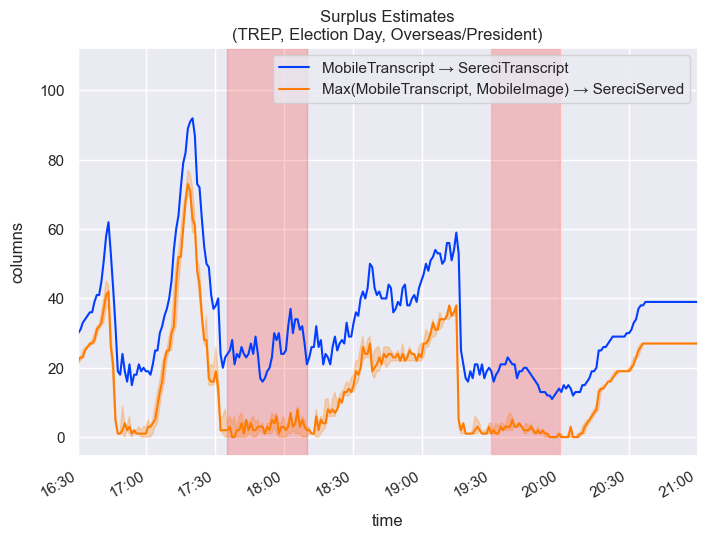

In [39]:
"""
    Curious detail: From 20:35-21:45, TREP-to-Cómputo image replications stop.
    It looks like the TSE isolated the Cómputo from the TREP in the post-alert panic.
"""
(
    (
        surplus[['MobileTranscript → SereciTranscript', 'MID:Eligible → SereciServed']]
            .rename(columns={'MID:Eligible → SereciServed': 'Max(MobileTranscript, MobileImage) → SereciServed'})
    )
    .plot(
        title='Surplus Estimates\n(TREP, Election Day, Overseas/President)',
        xlabel='time',
        xlim=pd.to_datetime(['2019-10-20 16:30', '2019-10-20 21:00']),
        x_compat=True,
        ylabel='columns'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
    .fill_between(
        surplus.index,
        surplus['MIN:Eligible → SereciServed'],
        surplus['MAX:Eligible → SereciServed'],
        alpha=0.25,
        color=sns.color_palette()[1]
    )
)

As I expected, it's effectively zero during both high-traffic periods. I think the small gap is due to a mix of fine timing issues, the *invalid image* problem, and a few other minor details I failed to account for. I've captured most of what's important, though, and the results support my claims of a shortage of verifiable acta columns.

There's an odd detail about the graph that I want to mention because it leads into another analysis of mine. While the new estimate hovers around zero at the expected times in Period #1, for Period #2 the estimate bottoms out 15 minutes sooner than expected and remains low for several minutes past the end of the period. The reason it continues past the end of Period #2 is because Period #2 acutally ends at 20:07, not 20:00, but the premature bottoming-out of the estimate has an unexpected cause: It's because the new estimate is based exclusively on overseas actas, and while surplus from all regions was exhausted at 19:32, surplus *from overseas* was exhausted at 19:15. The reason for this has to do with how the system sequenced acta columns for verification, which I explored in <i><a href="https://nbviewer.org/github/distantcomment/bolivia2019/blob/main/how-trep-counted-tally-sheets.ipynb">How Did Bolivia's 2019 TREP Count Tally Sheets?</a></i>.